[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justinhou95/DeepHedging/blob/main/deep%20efficient%20hedging.ipynb)

In [1]:
import sys
import os 
if '/content' in sys.path:
    if 'DeepHedging' in os.listdir():
        !rm -rf DeepHedging/
    !git clone https://github.com/justinhou95/DeepHedging/  
    import sys
    path = '/content/DeepHedging'
    if path not in sys.path:
        sys.path.append('/content/DeepHedging')

In [31]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
import utils.utils_efficient as utils_efficient
from importlib import reload 
print(tf.__version__)
reload(utils_efficient)

2.3.0


<module 'utils.utils_efficient' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils\\utils_efficient.py'>

In [32]:
reload(utils_efficient)
class EfficientHedgeCall:
    def __init__(self, po, trans_cost, L):
        self.trans_cost = trans_cost
        self.po = po
        self.N = N # time disrectization    
        self.S0 = S0 # initial value of the asset
        self.strike = strike
        self.K = strike
        self.L = L
        self.T = T
        self.dt = self.T / self.N
        self.initial_wealth = endow
        self.replicate_price = fp
        self.payoff_function = lambda x : 0.5*(np.abs(x-self.strike)+x-self.strike) # European call option payoff
        def ploss(payoff, outputs):
            if po == np.inf:
                self.strike_modified = self.L
#                 loss = tf.math.reduce_max(,keepdims = True)
                tmp = tf.sort(tf.nn.relu(payoff - outputs),axis = 0,direction='DESCENDING')
                loss = tf.reduce_mean(tmp[:100,:],keepdims = True)
                
                self.payoff_function_modified = lambda x : 0.5*(np.abs(x-self.strike_modified)+x-self.strike_modified) 
            elif po == 0:
                self.strike_modified = self.L
                loss = tf.math.sign(tf.nn.relu(payoff - outputs))
                self.payoff_function_modified = lambda x : (x-self.strike) * ((x < self.strike_modified) & (x > self.strike))
            elif po == 1:
                self.strike_modified = self.L
                loss = (tf.nn.relu(payoff - outputs))**po
                self.payoff_function_modified = lambda x : (x-self.strike) * (x > self.strike_modified) 
            else:
                if po < 1:
                    loss = (tf.nn.relu(payoff - outputs) + 1e-6)**po - 1e-6**po
                    payoff_function_modified  = lambda x: (x-self.K - (self.L/x)**(alpha/(self.po-1))*(self.L-self.K)) * (x > self.L)
                else:
                    loss = (tf.nn.relu(payoff - outputs))**po
                    payoff_function_modified  = lambda x: (x-self.K - (self.L/x)**(alpha/(self.po-1))*(self.L-self.K)) * (x > self.L)
                self.payoff_function_modified = payoff_function_modified
            return loss
        x = ploss(tf.ones(shape = [1,1]), tf.ones(shape = [1,1]))
        self.ploss = ploss

    def generate_data(self):        
        self.m = 1 # dimension of price
        self.mu = mu
        self.sigma = sigma
        self.Ktrain = 10**5
        self.price_path, self.time_grid = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             self.mu,self.sigma,self.S0, 'equi-exp')
        self.payoff = self.payoff_function(self.price_path[:,-1]) 
        self.payoff_modified = self.payoff_function_modified(self.price_path[:,-1])     

        self.delta_output, self.delta_path, self.option_path = utils_efficient.delta_hedge(self.price_path,\
            self.payoff_modified, self.T,self.strike, self.L,self.mu,self.sigma,self.po,self.time_grid)
        if self.trans_cost:
            self.delta_cost_output, self.hedge_cost_path, _ = utils_efficient.delta_hedge_cost(self.price_path,\
             self.payoff,self.T,self.strike, self.L,self.mu,self.sigma,self.po,self.time_grid)
                
    def plot_payoff(self):
        plt.figure(figsize = [8,3])
        plt.scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta payoff')
        plt.scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'payoff')
        plt.scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
        plt.legend()
        plt.xlim(0,600)
        plt.ylim(-100,500)
        plt.grid()
        plt.show()
        
    def build_model(self):
        self.model_hedge, self.Network0, self.Networks = utils_efficient.build_dynamic_cost(self.m, self.N, self.trans_cost, self.initial_wealth, self.ploss, self.po)
    
    def prepare_data(self):    
        self.split = int(self.Ktrain/2)
        self.xtrain = [self.price_path[:self.split], self.payoff[:self.split]]  # input be price_path
        self.ytrain = self.payoff[:self.split]*0  # output be payoff
        self.xtest = [self.price_path[self.split:], self.payoff[:self.split]]  # input be price_path
        self.ytest = self.payoff[self.split:]*0  # output be payoff      
    def train(self, epochs):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_predict*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall
        self.model_hedge.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=True,batch_size=256) # train the model
    def predict(self):
        self.hedge_output_train = self.model_hedge.predict(self.xtrain) # compute the output (deep replicate payoff) with trained model 
        self.hedge_output_test = self.model_hedge.predict(self.xtest) # compute the output (deep replicate payoff) with trained model
        trainloss = tf.reduce_mean(self.ploss(self.payoff[:self.split], self.hedge_output_train)).numpy()
        testloss = tf.reduce_mean(self.ploss(self.payoff[self.split:], self.hedge_output_test)).numpy()
        deltaloss = tf.reduce_mean(self.ploss(self.payoff, self.delta_output)).numpy()
        if self.trans_cost:
            delta_cost_loss = tf.reduce_mean(self.ploss(self.payoff, self.delta_cost_output)).numpy()
        print('ploss')
        if self.po not in [0,1,np.inf]:
            trainloss = trainloss**(1/self.po)
            testloss = testloss**(1/self.po)
            deltaloss = deltaloss**(1/self.po)
            if self.trans_cost:
                delta_cost_loss = delta_cost_loss**(1/self.po)
        print('train: ',trainloss)
        print('test: ',testloss)
        print('delta: ',deltaloss)
        if self.trans_cost:
            pic = 4
            print('delta(cost): ',delta_cost_loss)
        else:
            pic = 3
        f,p = plt.subplots(1,pic, figsize = [20,5], sharey = True, sharex = True)
        p[0].scatter(self.price_path[self.split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')
        p[1].scatter(self.price_path[:self.split,-1,0], self.hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train') 
        p[2].scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging')   
        if self.trans_cost:
            p[3].scatter(self.price_path[:,-1,0], self.delta_cost_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging (cost)')
            
        for i in range(pic):
            p[i].scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff') 
            p[i].legend()
            p[i].grid()
            if T > 1:
                plt.xlim(0,600)
                plt.ylim(-100,500)
        plt.show()
    def compare_strategy(self):
        f,p = plt.subplots(1,5,figsize = [20,5], sharey = True, sharex = True)
        for i in range(5):
            n = 20*i + 10
            pr = np.linspace(1,500,100)[:,None]  # tf.tensor of different price 

            he = self.Networks[n](tf.math.log(pr)) # the stategy network 
            p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy
            if self.po == 0:
                BS_func = utils_efficient.BS0
            elif self.po == 1:
                BS_func = utils_efficient.BS1
            elif self.po == np.inf:
                BS_func = utils_efficient.BSinf   
            else:
                BS_func = utils_efficient.BSp
            _ , delta = BS_func(self.T - self.time_grid[n], pr, self.strike,self.L, self.mu,self.sigma, self.po)
            p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            p[i].title.set_text(f"At time: {self.time_grid[n]:{1}.{4}}")
            p[i].legend()
            p[i].grid()
        plt.show()

## Numerical results

In [33]:
S0 = 100.0 # initial value of the asset
strike = 110.
K = strike
mu = 0.08
sigma = 0.3
alpha = mu/sigma**2
N = 100
T = 10
fp,_ = utils_efficient.BSinf(T, S0, strike,strike, mu,sigma, p=0)
ratio = 0.7
endow = ratio * fp
print('replicate price: ',fp)
print('intial endowment: ',endow)
print('ratio: ',ratio)

replicate price:  33.476981678735086
intial endowment:  23.43388717511456
ratio:  0.7


In [25]:
def test(p,cost):
    L = utils_efficient.solver(T,S0,strike,mu,sigma,p,endow)
    model = EfficientHedgeCall(p, cost, L)
    model.generate_data()
    model.plot_payoff()
    model.build_model()
    model.prepare_data()
    model.train(30)
    model.predict()
    model.compare_strategy()
    return model

668
23.441348528142456


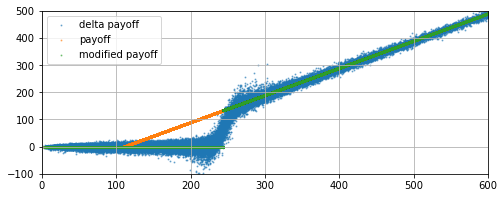

Epoch 1/30
196/196 [==============================] - 5s 24ms/step - loss: 266.6947 - p-loss: 69.4556 - 0-ad-loss: 196.4669
Epoch 2/30
196/196 [==============================] - 6s 29ms/step - loss: 56.7222 - p-loss: 45.6434 - 0-ad-loss: 11.0479: 1s - loss: 57.2006 - p-loss: 46.49
Epoch 3/30
196/196 [==============================] - 6s 29ms/step - loss: 48.3463 - p-loss: 38.2417 - 0-ad-loss: 10.0867
Epoch 4/30
196/196 [==============================] - 5s 27ms/step - loss: 44.0768 - p-loss: 35.2213 - 0-ad-loss: 8.8858
Epoch 5/30
196/196 [==============================] - 5s 26ms/step - loss: 43.5341 - p-loss: 35.1220 - 0-ad-loss: 8.4457
Epoch 6/30
196/196 [==============================] - 5s 27ms/step - loss: 42.8185 - p-loss: 33.9920 - 0-ad-loss: 8.8022
Epoch 7/30
196/196 [==============================] - 6s 29ms/step - loss: 42.1444 - p-loss: 33.5709 - 0-ad-loss: 8.5670
Epoch 8/30
196/196 [==============================] - 5s 25ms/step - loss: 41.9644 - p-loss: 33.5226 - 0-ad-loss

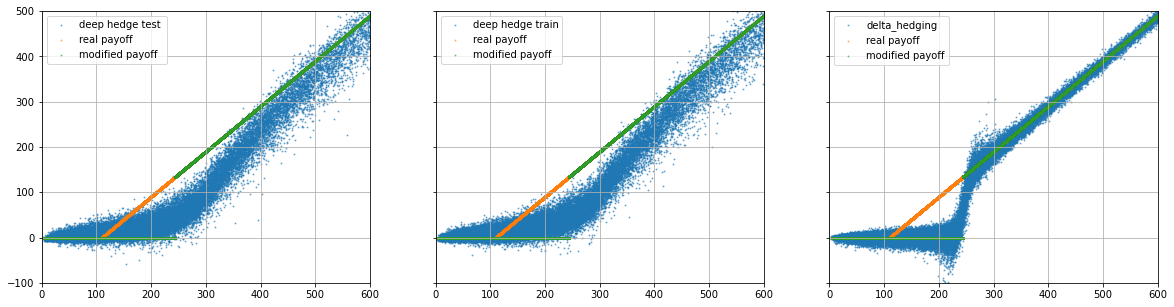

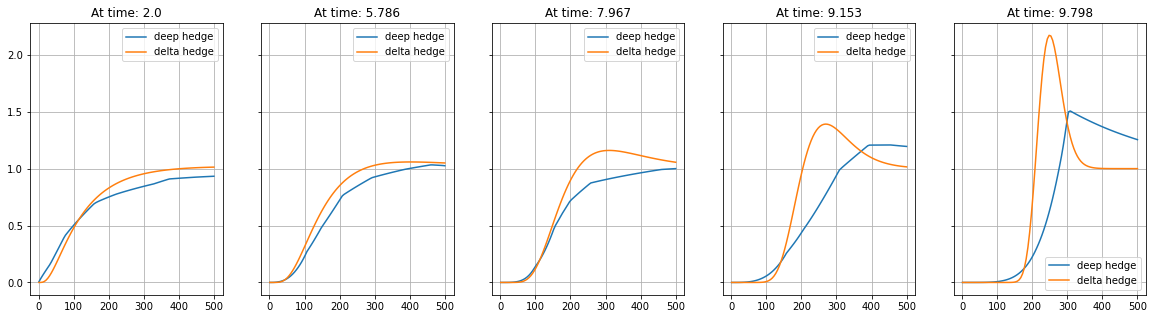

In [6]:
p = 1
cost = False
model_1 = test(p,cost)

668
23.42931381108701


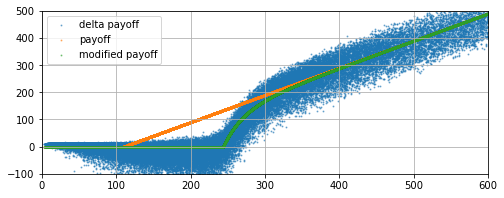

Epoch 1/30
196/196 [==============================] - 4s 20ms/step - loss: 257.7321 - p-loss: 86.3266 - 0-ad-loss: 170.7661
Epoch 2/30
196/196 [==============================] - 6s 30ms/step - loss: 63.4081 - p-loss: 49.7936 - 0-ad-loss: 13.5564: 2s - los
Epoch 3/30
196/196 [==============================] - 6s 31ms/step - loss: 50.6398 - p-loss: 40.4934 - 0-ad-loss: 10.1164: 1s - loss: 51.2581 - p-loss: 40
Epoch 4/30
196/196 [==============================] - 6s 30ms/step - loss: 46.7218 - p-loss: 36.8822 - 0-ad-loss: 9.8502
Epoch 5/30
196/196 [==============================] - 5s 25ms/step - loss: 44.4155 - p-loss: 35.1402 - 0-ad-loss: 9.2543
Epoch 6/30
196/196 [==============================] - 5s 26ms/step - loss: 44.6332 - p-loss: 35.1833 - 0-ad-loss: 9.4658
Epoch 7/30
196/196 [==============================] - 6s 29ms/step - loss: 44.4163 - p-loss: 35.0422 - 0-ad-loss: 9.3664
Epoch 8/30
196/196 [==============================] - 5s 25ms/step - loss: 43.2802 - p-loss: 34.2922 - 0-

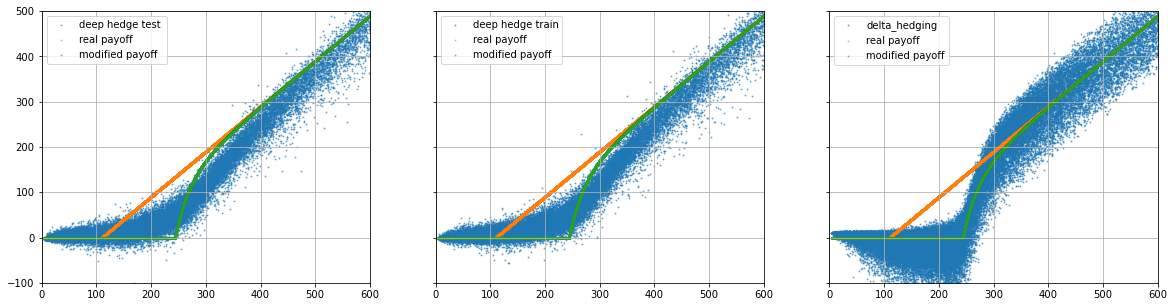

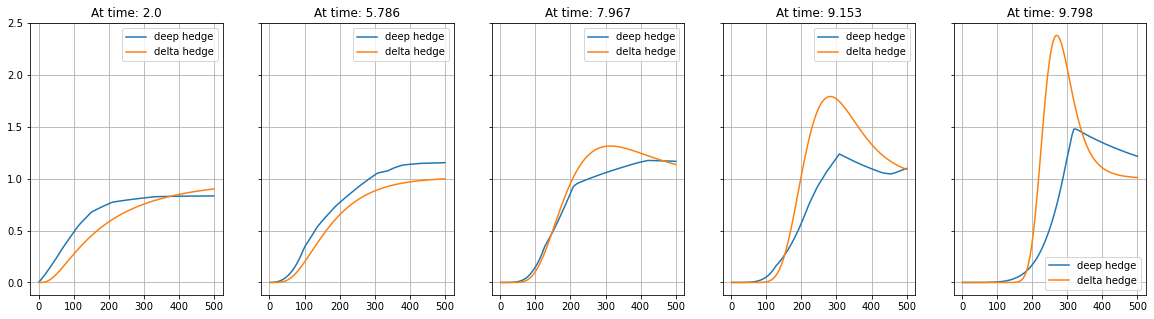

In [7]:
p = 1.1
cost = False
model_11 = test(p,cost)

253
23.44744224244743


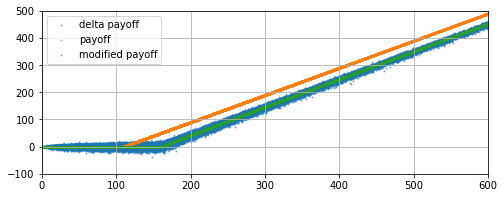

Epoch 1/30
196/196 [==============================] - 4s 21ms/step - loss: 529.9992 - p-loss: 189.4296 - 0-ad-loss: 339.2070
Epoch 2/30
196/196 [==============================] - 4s 22ms/step - loss: 177.2390 - p-loss: 131.0102 - 0-ad-loss: 45.9602: 3s - lo
Epoch 3/30
196/196 [==============================] - 5s 27ms/step - loss: 107.0716 - p-loss: 82.1370 - 0-ad-loss: 24.8318 0s - loss: 107.1186 - p-loss: 82.2523 - 0-ad-loss: 24.86
Epoch 4/30
196/196 [==============================] - 5s 27ms/step - loss: 131.4133 - p-loss: 97.5019 - 0-ad-loss: 33.8074
Epoch 5/30
196/196 [==============================] - 5s 25ms/step - loss: 113.4116 - p-loss: 84.6189 - 0-ad-loss: 28.7271
Epoch 6/30
196/196 [==============================] - 5s 26ms/step - loss: 92.7060 - p-loss: 69.4458 - 0-ad-loss: 23.1865: 1s - loss: 96.5006 - p-loss:
Epoch 7/30
196/196 [==============================] - 5s 24ms/step - loss: 93.0260 - p-loss: 68.2762 - 0-ad-loss: 24.7393
Epoch 8/30
196/196 [======================

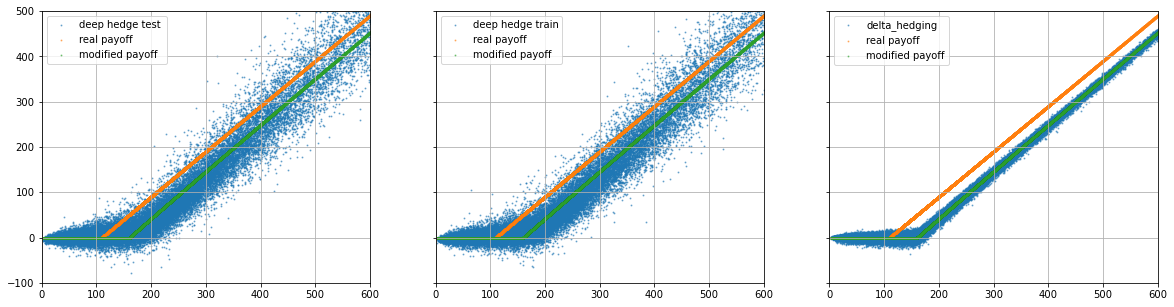

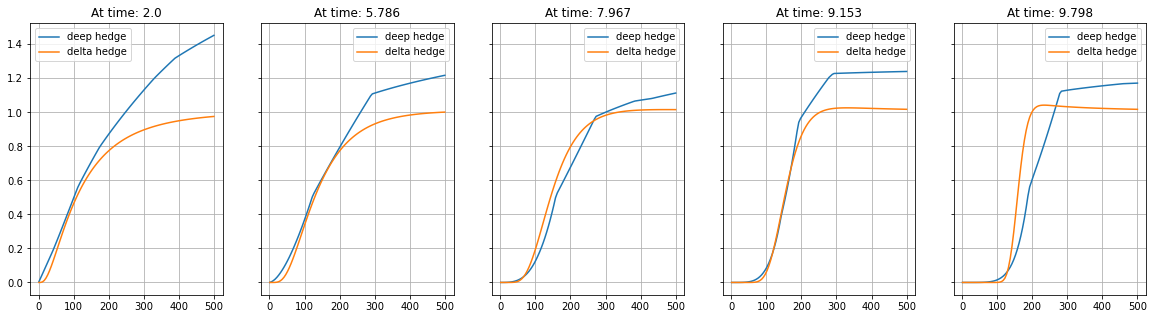

In [8]:
p = 5
cost = False
model_5 = test(p,cost)

225
23.429445281646046


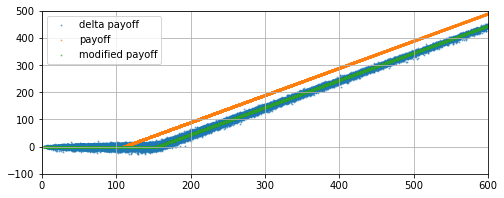

Epoch 1/30
196/196 [==============================] - 4s 22ms/step - loss: 314.9697 - p-loss: 109.8295 - 0-ad-loss: 204.2477
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 89.1572 - p-loss: 61.7469 - 0-ad-loss: 27.2979: 0s - loss: 89.2119 - p-loss: 61.8705 - 0-ad-loss: 27.341
Epoch 3/30
196/196 [==============================] - 5s 25ms/step - loss: 80.6772 - p-loss: 54.2057 - 0-ad-loss: 26.3458: 3s - loss: 81.4052 - p-loss: 56.4860 - 0-ad-lo - ETA: 3s - loss: 82.2540 - p-loss: 56.7937 - 0-ad-loss:  - ETA: 2s - loss: 81.2104 - p-lo - ETA: 0s - loss: 80.9638 - p-loss: 54.6254 - 0
Epoch 4/30
196/196 [==============================] - 6s 32ms/step - loss: 75.9561 - p-loss: 51.1203 - 0-ad-loss: 24.8113
Epoch 5/30
196/196 [==============================] - 6s 29ms/step - loss: 74.1732 - p-loss: 49.6725 - 0-ad-loss: 24.3852
Epoch 6/30
196/196 [==============================] - 6s 33ms/step - loss: 74.2424 - p-loss: 48.9764 - 0-ad-loss: 25.1632
Epoch 7/30
196/196 [

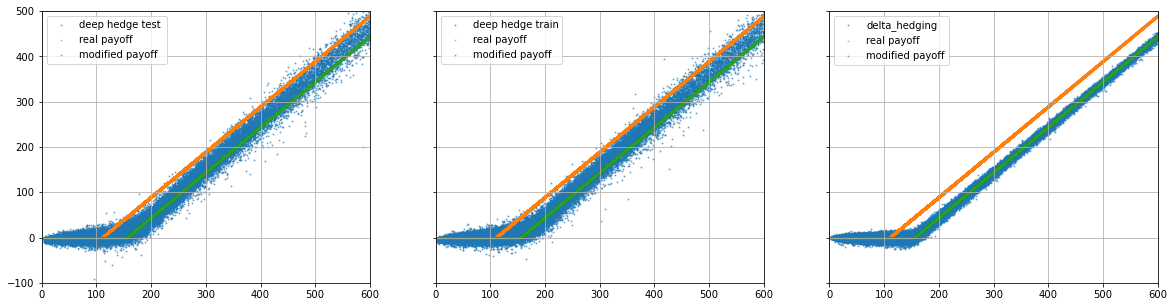

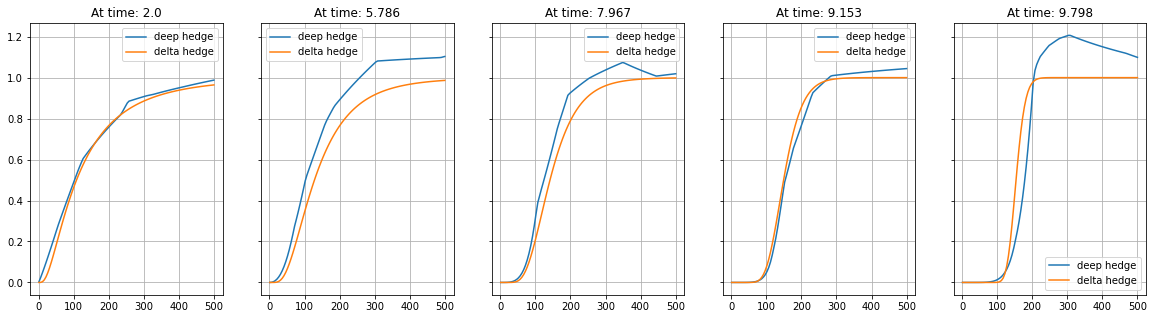

In [9]:
p = np.inf
cost = False
model_inf = test(p,cost)

## transaction cost

668
23.441348528142456


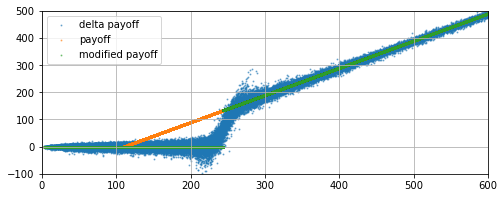

Epoch 1/30
196/196 [==============================] - 5s 23ms/step - loss: 370.4629 - p-loss: 75.4528 - 0-ad-loss: 293.8760 - tran_cost: 37.0243
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 64.3764 - p-loss: 54.9647 - 0-ad-loss: 9.3977 - tran_cost: 13.8068: 3s - loss: 67.494
Epoch 3/30
196/196 [==============================] - 5s 27ms/step - loss: 56.3908 - p-loss: 48.0264 - 0-ad-loss: 8.3989 - tran_cost: 13.6031: 3s - los
Epoch 4/30
196/196 [==============================] - 5s 26ms/step - loss: 53.0896 - p-loss: 45.2364 - 0-ad-loss: 7.8860 - tran_cost: 12.2842
Epoch 5/30
196/196 [==============================] - 5s 26ms/step - loss: 54.9284 - p-loss: 46.6165 - 0-ad-loss: 8.3069 - tran_cost: 12.8583: 2s - loss: 56.0394 -
Epoch 6/30
196/196 [==============================] - 8s 40ms/step - loss: 51.8368 - p-loss: 43.9992 - 0-ad-loss: 7.8320 - tran_cost: 11.4924: 0s - loss: 51.8705 - p-loss: 44.0182 - 0-ad-loss: 7.8524 - tran_cost: 11.5
Epoch 7/30
196/196

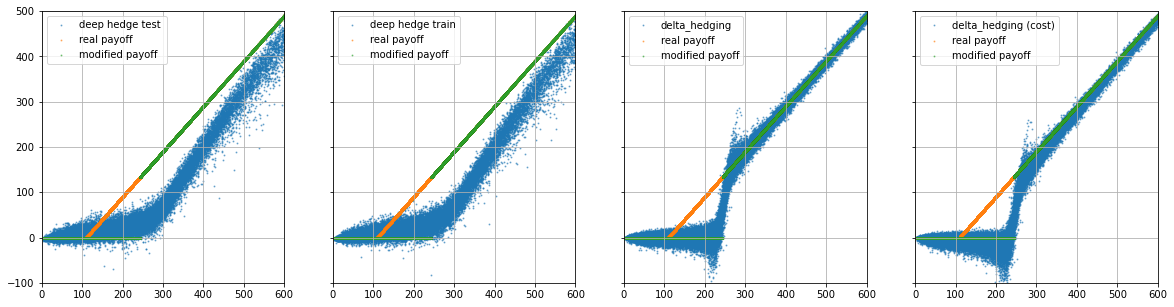

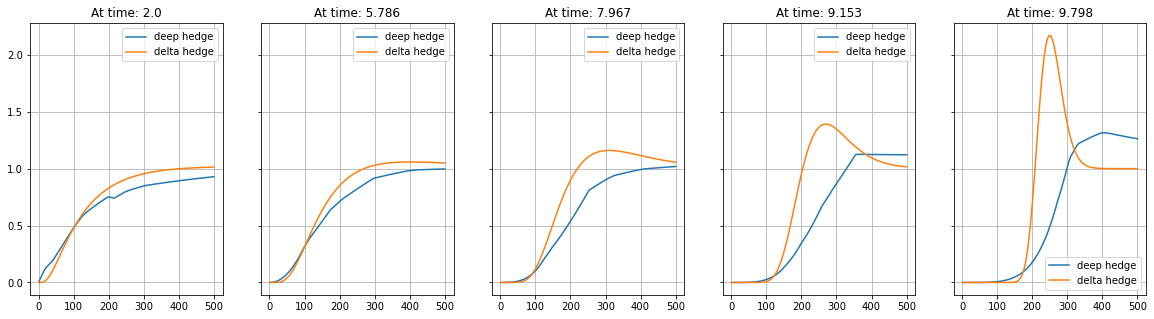

In [10]:
p = 1
cost = True
model_1_cost = test(p,cost)

668
23.42931381108701


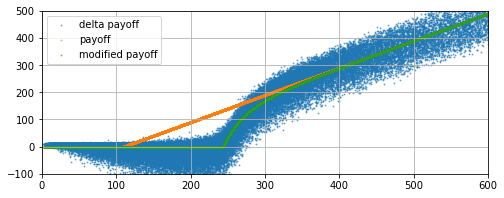

Epoch 1/30
196/196 [==============================] - 6s 30ms/step - loss: 369.1650 - p-loss: 80.1519 - 0-ad-loss: 287.9525 - tran_cost: 39.5667
Epoch 2/30
196/196 [==============================] - 6s 30ms/step - loss: 66.4844 - p-loss: 55.9706 - 0-ad-loss: 10.4612 - tran_cost: 15.0964
Epoch 3/30
196/196 [==============================] - 6s 32ms/step - loss: 59.0340 - p-loss: 49.4546 - 0-ad-loss: 9.6164 - tran_cost: 12.9833
Epoch 4/30
196/196 [==============================] - 5s 28ms/step - loss: 56.3855 - p-loss: 47.6220 - 0-ad-loss: 8.7900 - tran_cost: 12.0007
Epoch 5/30
196/196 [==============================] - 6s 29ms/step - loss: 56.3124 - p-loss: 47.3157 - 0-ad-loss: 8.9959 - tran_cost: 11.9198
Epoch 6/30
196/196 [==============================] - 5s 28ms/step - loss: 54.3409 - p-loss: 45.8979 - 0-ad-loss: 8.4535 - tran_cost: 11.2530
Epoch 7/30
196/196 [==============================] - 5s 28ms/step - loss: 53.5607 - p-loss: 45.2881 - 0-ad-loss: 8.3032 - tran_cost: 10.9084
Ep

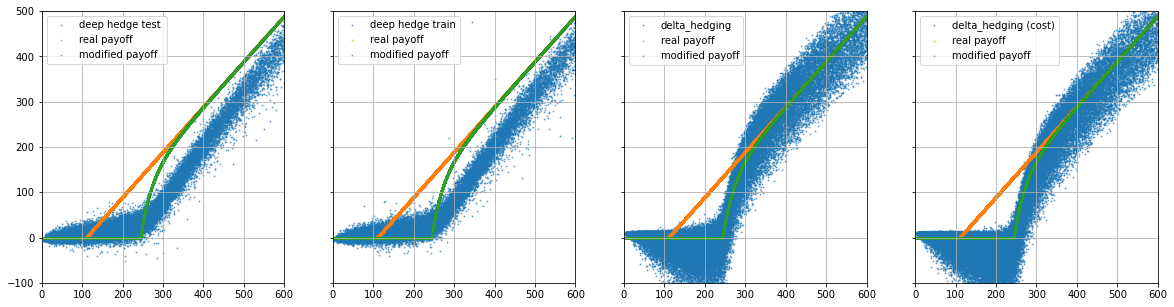

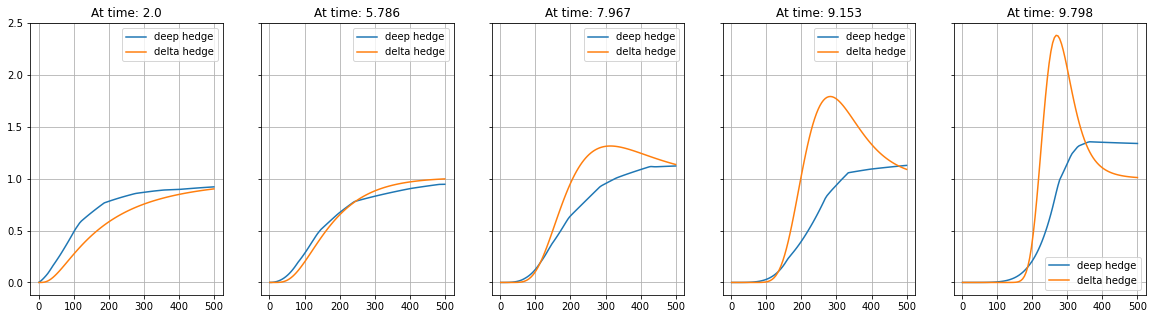

In [11]:
p = 1.1
cost = True
model_11_cost = test(p,cost)

253
23.44744224244743


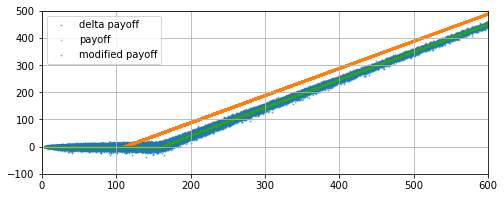

Epoch 1/30
196/196 [==============================] - 6s 31ms/step - loss: 669.9738 - p-loss: 185.1774 - 0-ad-loss: 483.1317 - tran_cost: 85.5538: 1s - loss: 786.6477 - p-loss: 182.7336 - 0-ad-loss: 60
Epoch 2/30
196/196 [==============================] - 8s 42ms/step - loss: 165.9871 - p-loss: 124.0599 - 0-ad-loss: 41.9392 - tran_cost: 26.5609
Epoch 3/30
196/196 [==============================] - 6s 30ms/step - loss: 135.6119 - p-loss: 102.0191 - 0-ad-loss: 33.6179 - tran_cost: 20.7686
Epoch 4/30
196/196 [==============================] - 6s 31ms/step - loss: 142.3296 - p-loss: 104.2847 - 0-ad-loss: 37.9324 - tran_cost: 21.2730
Epoch 5/30
196/196 [==============================] - 7s 34ms/step - loss: 103.8664 - p-loss: 74.4030 - 0-ad-loss: 29.4284 - tran_cost: 14.3578
Epoch 6/30
196/196 [==============================] - 7s 34ms/step - loss: 103.5171 - p-loss: 75.1550 - 0-ad-loss: 28.4499 - tran_cost: 14.2992
Epoch 7/30
196/196 [==============================] - 7s 33ms/step - loss: 

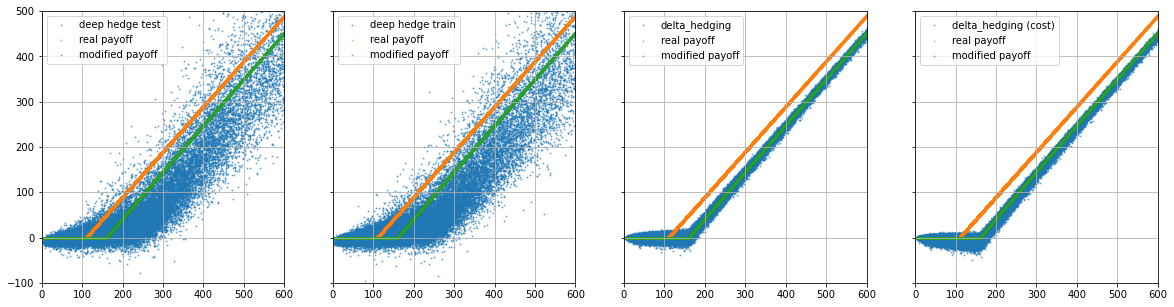

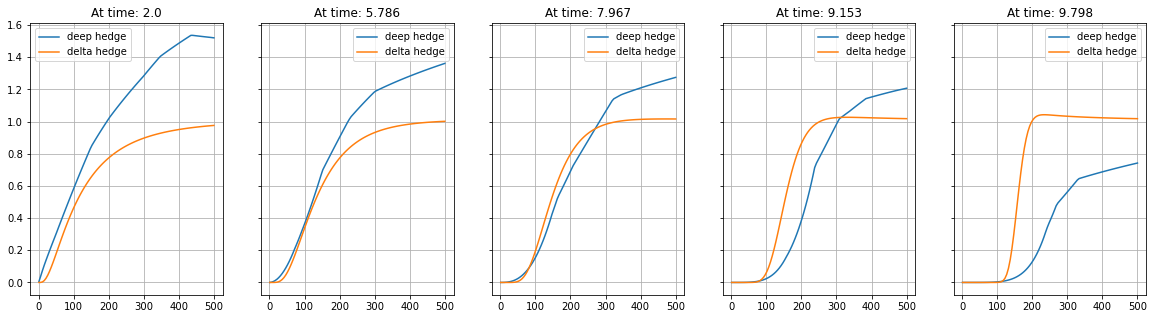

In [12]:
p = 5
cost = True
model_5_cost = test(p,cost)

225
23.429445281646046


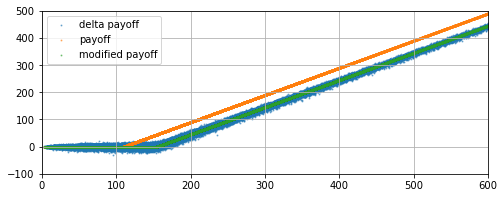

Epoch 1/30
196/196 [==============================] - 6s 32ms/step - loss: 442.7595 - p-loss: 132.0980 - 0-ad-loss: 309.3953 - tran_cost: 41.4716TA: 4s 
Epoch 2/30
196/196 [==============================] - 9s 47ms/step - loss: 107.3020 - p-loss: 74.9227 - 0-ad-loss: 32.1932 - tran_cost: 14.4687: 4s - loss: 113.3589 - p-loss: 80.5186 - 0-ad-loss: 32.8403 - tran_cost - ETA
Epoch 3/30
196/196 [==============================] - 10s 48ms/step - loss: 94.2664 - p-loss: 64.2713 - 0-ad-loss: 29.8833 - tran_cost: 11.3603
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 91.4221 - p-loss: 60.8497 - 0-ad-loss: 30.4287 - tran_cost: 10.5537
Epoch 5/30
196/196 [==============================] - 9s 47ms/step - loss: 89.5189 - p-loss: 58.6939 - 0-ad-loss: 30.7814 - tran_cost: 10.0885
Epoch 6/30
196/196 [==============================] - 9s 47ms/step - loss: 89.6575 - p-loss: 58.8659 - 0-ad-loss: 30.7053 - tran_cost: 10.0244
Epoch 7/30
196/196 [==============================] 

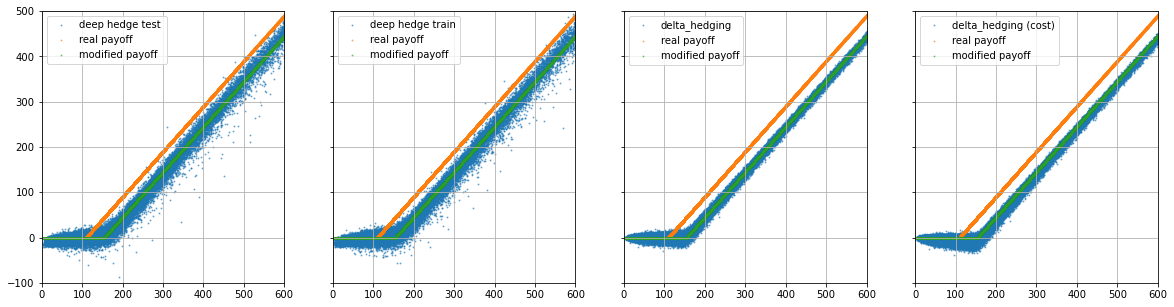

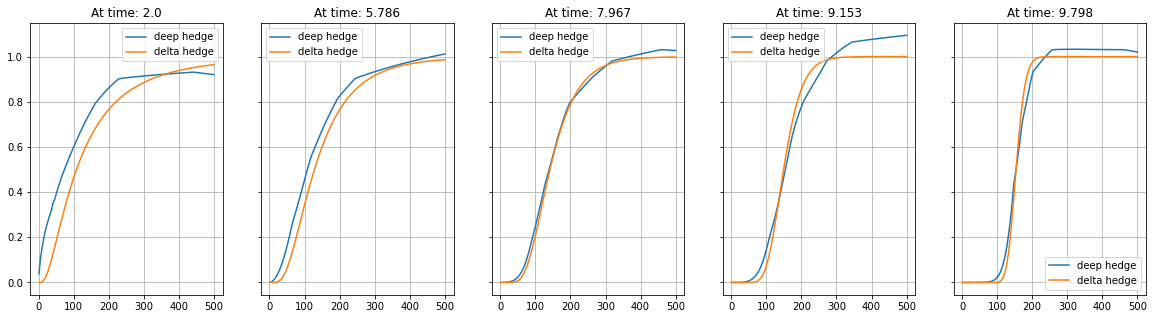

In [13]:
p = np.inf
cost = True
model_inf_cost = test(p,cost)

## Limitations

999
15.101062383914247


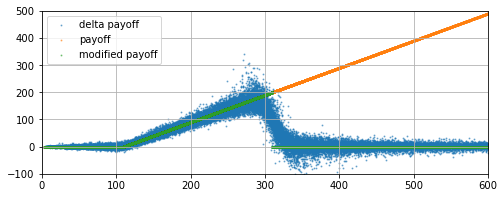

Epoch 1/30
196/196 [==============================] - 6s 30ms/step - loss: 170.6345 - p-loss: 0.5101 - 0-ad-loss: 169.5277
Epoch 2/30
196/196 [==============================] - 301s 2s/step - loss: 0.5220 - p-loss: 0.5211 - 0-ad-loss: 8.5064e-04A: 34s - loss: 0.5220 - p-loss: 0.5210 - 0-ad-los
Epoch 3/30
196/196 [==============================] - 5s 28ms/step - loss: 0.5214 - p-loss: 0.5214 - 0-ad-loss: 1.9002e-04
Epoch 4/30
196/196 [==============================] - 7s 34ms/step - loss: 0.5219 - p-loss: 0.5209 - 0-ad-loss: 7.0300e-04
Epoch 5/30
196/196 [==============================] - 7s 34ms/step - loss: 0.5201 - p-loss: 0.5203 - 0-ad-loss: 0.0000e+00
Epoch 6/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5206 - p-loss: 0.5206 - 0-ad-loss: 0.0000e+00
Epoch 7/30
196/196 [==============================] - 6s 33ms/step - loss: 0.5205 - p-loss: 0.5204 - 0-ad-loss: 0.0000e+00
Epoch 8/30
196/196 [==============================] - 7s 34ms/step - loss: 0.5203 - p-loss

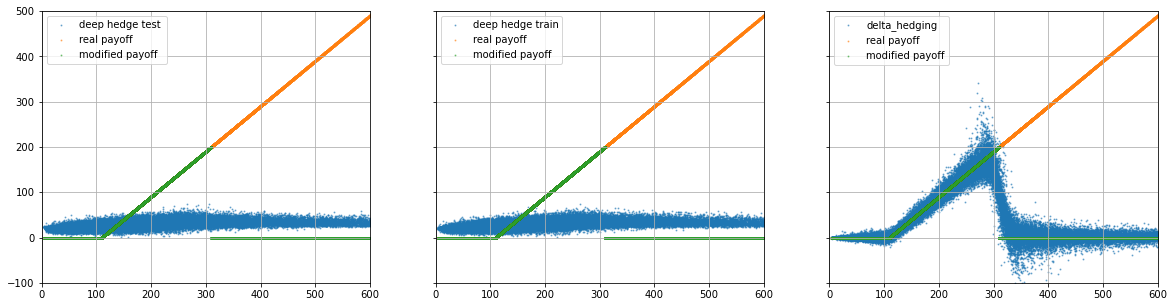

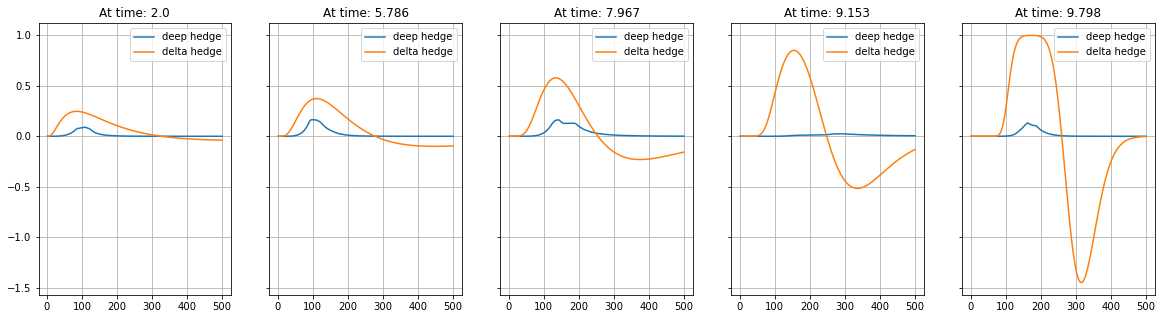

In [8]:
p = 0
cost = False
model0 = test(p,cost)

47
23.344516076387507


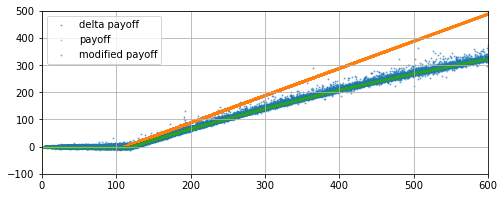

Epoch 1/30
196/196 [==============================] - 4s 22ms/step - loss: 196.8144 - p-loss: 30.4523 - 0-ad-loss: 165.7803
Epoch 2/30
196/196 [==============================] - 5s 26ms/step - loss: 28.8304 - p-loss: 27.2315 - 0-ad-loss: 1.6222
Epoch 3/30
196/196 [==============================] - 5s 27ms/step - loss: 25.0725 - p-loss: 23.3404 - 0-ad-loss: 1.7264
Epoch 4/30
196/196 [==============================] - 5s 27ms/step - loss: 24.9535 - p-loss: 23.1801 - 0-ad-loss: 1.7373
Epoch 5/30
196/196 [==============================] - 5s 27ms/step - loss: 28.9942 - p-loss: 25.4441 - 0-ad-loss: 3.6099
Epoch 6/30
196/196 [==============================] - 5s 27ms/step - loss: 31.4003 - p-loss: 30.1268 - 0-ad-loss: 1.2686
Epoch 7/30
196/196 [==============================] - 5s 28ms/step - loss: 26.2445 - p-loss: 24.7122 - 0-ad-loss: 1.5302
Epoch 8/30
196/196 [==============================] - 6s 30ms/step - loss: 25.3115 - p-loss: 23.4972 - 0-ad-loss: 1.8307
Epoch 9/30
196/196 [=========

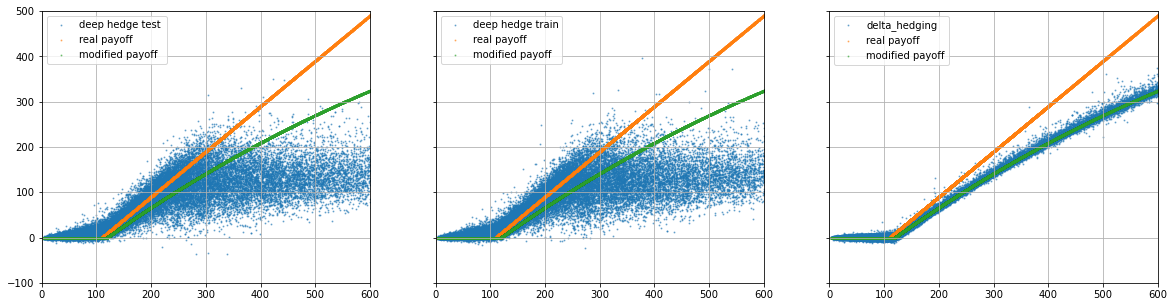

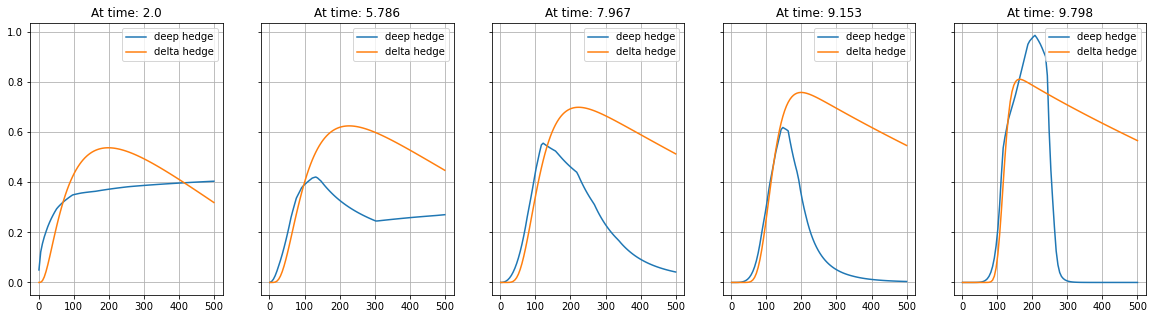

In [34]:
p = 0.5
cost = False
model05 = test(p,cost)

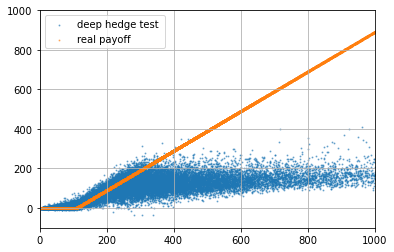

In [38]:
self = model05 
plt.scatter(self.price_path[self.split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')
plt.scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
plt.legend()
plt.grid()
plt.xlim(0,1000)
plt.ylim(-100,1000)
plt.show()

In [39]:
S0 = 100.0 # initial value of the asset
strike = 110.
K = strike
mu = 0.08
sigma = 0.3
alpha = mu/sigma**2
N = 100
T = 1
fp,_ = utils_efficient.BSinf(T, S0, strike,strike, mu,sigma, p=0)
ratio = 0.7
endow = ratio * fp
print('replicate price: ',fp)
print('intial endowment: ',endow)
print('ratio: ',ratio)

replicate price:  8.1410120489642
intial endowment:  5.6987084342749394
ratio:  0.7


137
5.697088495577997


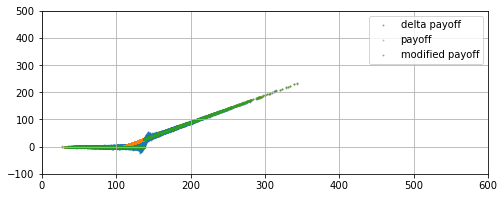

Epoch 1/30
196/196 [==============================] - 3s 14ms/step - loss: 64.1585 - p-loss: 11.0253 - 0-ad-loss: 52.9258
Epoch 2/30
196/196 [==============================] - 3s 15ms/step - loss: 8.6676 - p-loss: 8.5151 - 0-ad-loss: 0.1521
Epoch 3/30
196/196 [==============================] - 3s 15ms/step - loss: 8.2471 - p-loss: 8.0139 - 0-ad-loss: 0.2366
Epoch 4/30
196/196 [==============================] - 3s 15ms/step - loss: 7.6962 - p-loss: 7.3760 - 0-ad-loss: 0.3226
Epoch 5/30
196/196 [==============================] - 3s 15ms/step - loss: 6.9665 - p-loss: 6.5663 - 0-ad-loss: 0.4025
Epoch 6/30
196/196 [==============================] - 3s 15ms/step - loss: 6.5219 - p-loss: 6.0883 - 0-ad-loss: 0.4386 1s - loss: - ETA: 0s - loss: 6.5088 - p-loss: 6.0709 - 0
Epoch 7/30
196/196 [==============================] - 3s 15ms/step - loss: 6.3444 - p-loss: 5.8741 - 0-ad-loss: 0.4706
Epoch 8/30
196/196 [==============================] - 3s 15ms/step - loss: 6.2854 - p-loss: 5.8462 - 0-ad-l

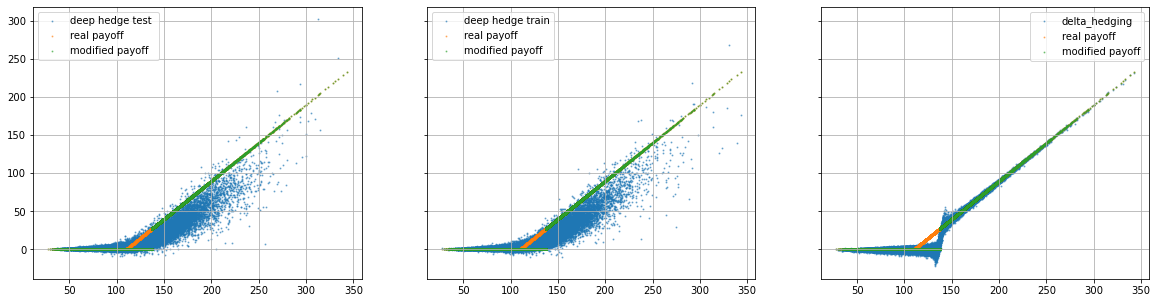

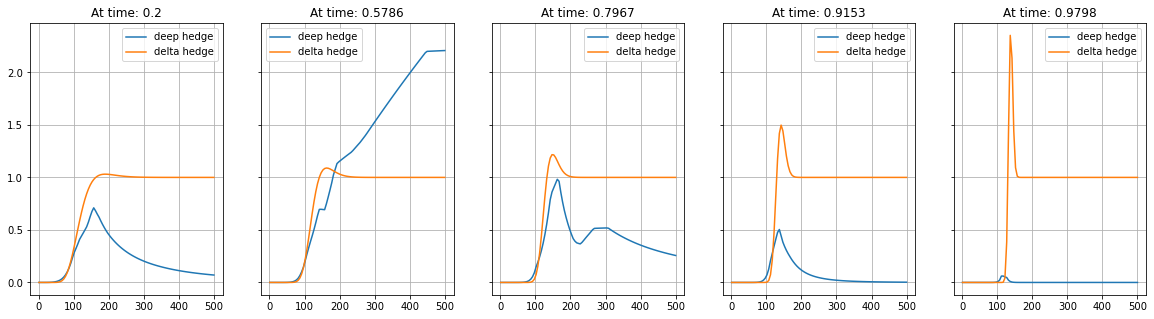

In [28]:
p = 1
cost = False
model05 = test(p,cost)

68
5.713191069495166


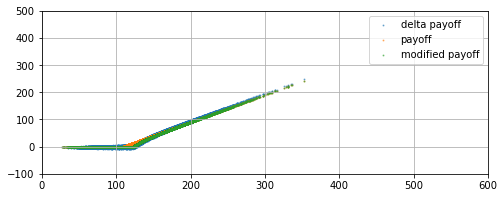

Epoch 1/30
196/196 [==============================] - 5s 28ms/step - loss: 64.7971 - p-loss: 12.4019 - 0-ad-loss: 52.2092
Epoch 2/30
196/196 [==============================] - 5s 27ms/step - loss: 10.0664 - p-loss: 9.9088 - 0-ad-loss: 0.1509
Epoch 3/30
196/196 [==============================] - 5s 28ms/step - loss: 9.5183 - p-loss: 9.2324 - 0-ad-loss: 0.2835
Epoch 4/30
196/196 [==============================] - 6s 28ms/step - loss: 8.8660 - p-loss: 8.4608 - 0-ad-loss: 0.3944
Epoch 5/30
196/196 [==============================] - 5s 28ms/step - loss: 7.8780 - p-loss: 7.3564 - 0-ad-loss: 0.5287
Epoch 6/30
196/196 [==============================] - 6s 29ms/step - loss: 7.3159 - p-loss: 6.6989 - 0-ad-loss: 0.6187
Epoch 7/30
196/196 [==============================] - 6s 29ms/step - loss: 7.1138 - p-loss: 6.4937 - 0-ad-loss: 0.6210
Epoch 8/30
196/196 [==============================] - 6s 28ms/step - loss: 6.8593 - p-loss: 6.2088 - 0-ad-loss: 0.6524
Epoch 9/30
196/196 [========================

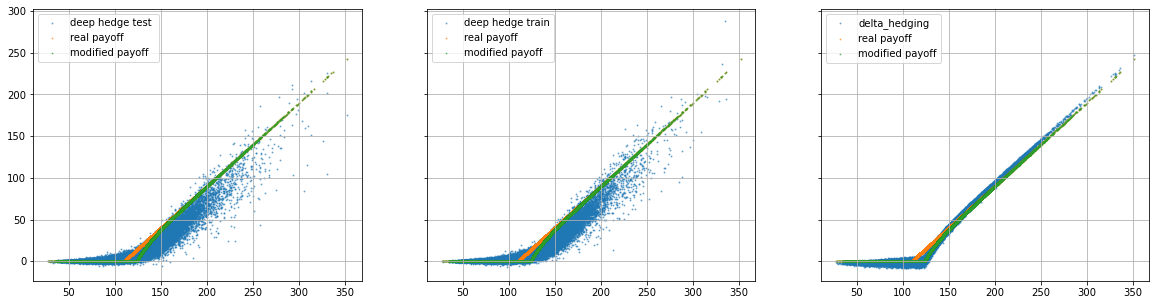

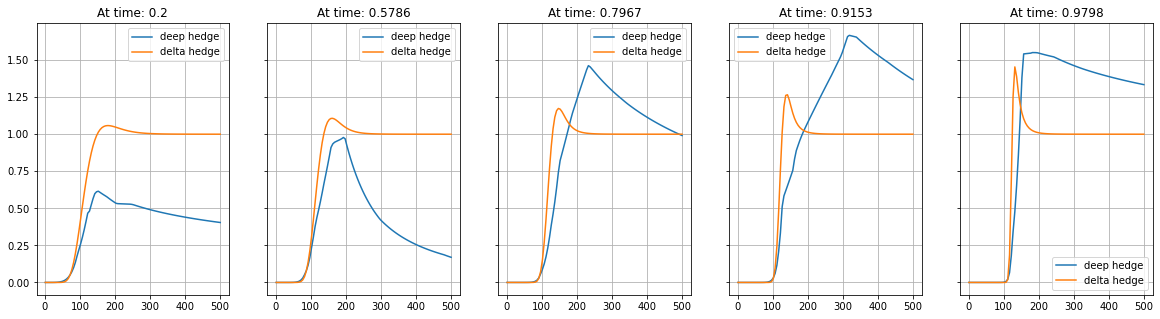

In [40]:
p = 1.1
cost = False
model05 = test(p,cost)